In [1]:
!splitcode --version
!fasterq-dump --version

splitcode, version 0.30.0

fasterq-dump : 3.0.3 ( 3.0.2 )



In [2]:
import multiprocessing

outdir = "/mnt/data1/10XvParse/Analysis_3/"
fasta_folder = "FASTA/Raw/"
sra_folder = "SRA/"
tmp_folder = "tmp/"
proc_folder = "FASTA/Processed/"

sample_names = ["H1","H2"]

In [3]:
file_names = []
srrs = []

with open("parse_extraction/parse_accession.txt") as access:
    for line in access:
        line = line.strip()
        if line.startswith('H'):
            i = 0
            name = f"Parse_{line}"
        else:
            i += 1
            filename = f"{name}_{i}"
            file_names.append(filename)
            srrs.append(line)

In [ ]:
for srr, name in zip(srrs, file_names):
    print(outdir+fasta_folder+name)
    !prefetch {srr} --max-size u -O {outdir+sra_folder}
    !fasterq-dump --outdir {outdir+fasta_folder} --temp {outdir+tmp_folder} \
        --outfile {name+".fastq"} --split-files --skip-technical \
        {outdir+sra_folder+srr+"/"+srr+".sra"} --threads 8
    !pigz {outdir+fasta_folder+name+"_1.fastq"} -p 8
    !pigz {outdir+fasta_folder+name+"_2.fastq"} -p 8

/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1

2025-08-14T21:54:09 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-14T21:54:09 prefetch.3.0.3: 1) 'SRR26594152' is found locally
2025-08-14T21:54:10 prefetch.3.0.3: 'SRR26594152' has 0 unresolved dependencies
spots read      : 1,390,885
reads read      : 2,781,770
reads written   : 2,781,770
^C
pigz: skipping: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1_1.fastq does not exist
pigz: skipping: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1_2.fastq does not exist
/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_2

2025-08-14T21:54:14 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-14T21:54:15 prefetch.3.0.3: 1) 'SRR26594150' is found locally
2025-08-14T21:54:15 prefetch.3.0.3: 'SRR26594150' has 0 unresolved dependencies


In [ ]:
for name in sample_names:
    batch_file = f"batch/parse_batch_{name}.txt"
    with open(batch_file, "w") as batch:
        for file in file_names:
            if name in file:
                fastq_files = [outdir + fasta_folder + file + "_1.fastq.gz", 
                        outdir + fasta_folder + file + "_2.fastq.gz"]
                batch.write(f"{file}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [ ]:
def remultiplex(name):
    batch_file = f"batch/parse_batch_{name}.txt"
    mapping = f"run_info/parse_{name}_mapping.txt"
    outb = f"run_info/parse_{name}_barcodes.fastq.gz"
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fastq.gz",
                  outdir + proc_folder + f"parse_{name}_2.fastq.gz"]
    !splitcode --remultiplex -c parse_extraction/config_correct.txt\
        --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
        --outb={outb} --mapping={mapping} {batch_file} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(remultiplex,sample_names)
    print("done")

* Using a list of 384 tags (vector size: 384; map size: 8,858; num elements in map: 12,672)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1_2.fastq.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_2_2.fastq.gz
* will process sample 3: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_3_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_3_2.fastq.gz
* will process sample 4: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_4_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_4_2.fastq.gz
* will process sample 5: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_5_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_5_2.fastq.gz
* will process sam

In [ ]:
batch_file = f"batch/parse_batch.txt"
with open(batch_file, "w") as batch:
    for name in sample_names:
        file = f"parse_{name}"
        fastq_files = [outdir + proc_folder + file + "_1.fastq.gz", 
                outdir + proc_folder + file + "_2.fastq.gz"]
        batch.write(f"{name}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [ ]:
mapping = f"run_info/parse_mapping.txt"
outb = f"run_info/parse_barcodes.fastq.gz"
proc_files = [outdir + fasta_folder + f"parse_1.fastq.gz",
                outdir + fasta_folder + f"parse_2.fastq.gz"]
!splitcode --remultiplex -c parse_extraction/config_correct.txt\
    --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
    --outb={outb} --mapping={mapping} {batch_file} -t 8

In [7]:
distances = 1
locations = "1:78:86"
with open("parse_extraction/config_RT.txt", "w") as config:
    config.write("tags\tsubs\tdistances\tlocations\n")
    with open("parse_extraction/r1_R.txt") as randO:
        with open("parse_extraction/r1_T.txt") as polyT:
            for lineO, lineT in zip(randO,polyT):
                lineO = lineO.strip()
                lineT = lineT.strip()
                config.write(f"{lineO}\t{lineT}\t{distances}\t{locations}\n")

In [8]:
# Divide the reads into different wells

with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    n = 0
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" + outdir + "FASTA/wells/randO_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    n = 0
    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" + outdir +  "FASTA/wells/polyT_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

In [20]:
# Extract by well
!splitcode -c parse_extraction/config_wells.txt --gzip --keep-r1-r2 \
    --keep=parse_extraction/keep_wells.txt --nFastqs=2 --no-output \
    --no-outb {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_2.fastq.gz
455M reads processed         
done 
* processed 463,516,646 reads


In [ ]:
# Extract polyT reads
def extractPolyT(name):
    polyT_files = [outdir+proc_folder+f"polyT_{name}_1.fastq.gz",
                   outdir+proc_folder+f"polyT_{name}_2.fastq.gz"]
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fastq.gz",
                  outdir + proc_folder + f"parse_{name}_2.fastq.gz"]
    
    !splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
        --assign -o {polyT_files[0]},{polyT_files[1]} \
        --outb=run_info/polyT_barcodes.fastq.gz --mapping=run_info/polyT_mapping.txt --summary=run_info/polyT_summary.txt \
        {proc_files[0]} {proc_files[1]} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(extractPolyT,sample_names)
    print("done")

* Using a list of 288 tags (vector size: 288; map size: 6,072; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_2.fastq.gz
* processing the reads ...* Using a list of 288 tags (vector size: 288; map size: 6,072; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_2.fastq.gz
207M reads processed (63.8% assigned)
done 
* processed 223,815,705 reads, 130,022,511 reads were assigned
231M reads processed (63.7% assigned)
done 
* processed 239,700,941 reads, 152,772,815 reads were assigned
done


In [ ]:
# Extract randO reads
def extractRandO(name):
    randO_files = [outdir+proc_folder+f"randO_{name}_1.fastq.gz",
                   outdir+proc_folder+f"randO_{name}_2.fastq.gz"]
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fastq.gz",
                  outdir + proc_folder + f"parse_{name}_2.fastq.gz"]
    
    !splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
        --assign -o {randO_files[0]},{randO_files[1]} \
        --outb=run_info/randO_barcodes.fastq.gz --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
        {proc_files[0]} {proc_files[1]} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(extractRandO,sample_names)
    print("done")

* Using a list of 288 tags (vector size: 288; map size: 6,079; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_2.fastq.gz
* processing the reads ...* Using a list of 288 tags (vector size: 288; map size: 6,079; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_2.fastq.gz
215M reads processed (41.9% assigned)
done 
* processed 239,700,941 reads, 86,928,126 reads were assigned

done 
* processed 223,815,705 reads, 93,793,194 reads were assigned
done


In [14]:
# Download human genome
!kb ref --overwrite -d human -i index.idx -g t2g.txt

[2025-08-13 21:46:34,008]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|████████████████████████████████████████| 138M/138M [00:01<00:00, 97.9MB/s]
[2025-08-13 21:46:35,493]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


In [21]:
# Prepare batch file to pseudalign reads by well
rando_well = outdir + "FASTA/wells/randO_well_"
polyt_well = outdir + "FASTA/wells/polyT_well_"
with open("parse_extraction/batch_wells.txt", "w") as batch:
    batch.truncate()
    for n in range(1,97):
        batch.write("RandO_Well" + str(n) + "\t" + rando_well + str(n) + "_R1.fastq.gz\t" + rando_well + str(n) + "_R2.fastq.gz\n")
    for n in range(1,97):
        batch.write("PolyT_Well" + str(n) + "\t" + polyt_well + str(n) + "_R1.fastq.gz\t" + polyt_well + str(n) + "_R2.fastq.gz\n")

In [15]:
def alignParse(name):  
    parse_out = outdir + f"parse_{name}_out"
    proc_files = [outdir + fasta_folder + f"parse_{name}_1.fastq.gz",
                  outdir + fasta_folder + f"parse_{name}_2.fastq.gz"]
    # Pseudoalign all parse reads
    !kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {parse_out} {proc_files[0]} {proc_files[1]}
with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignParse,sample_names)
    print("done")

[2025-08-13 21:47:56,769]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/parse_H2_out from
[2025-08-13 21:47:56,769]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_1.fastq.gz
[2025-08-13 21:47:56,769]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H2_2.fastq.gz
[2025-08-13 21:47:56,797]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/parse_H1_out from
[2025-08-13 21:47:56,797]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_1.fastq.gz
[2025-08-13 21:47:56,797]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_H1_2.fastq.gz
[2025-08-13 22:09:04,061]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/parse_H2_out/output.bus to /mnt/data1/10XvParse/Analysis_3/parse_H2_out/tmp/output.s.bus
[2025-08-13 22:09:15,179]    INFO [count] On-list not provided
[2025-08-13 22:09:15,179]    INFO

In [22]:
wells_out = outdir + "wells_out"
# Pseudoalign parse reads by well
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {wells_out} --batch-barcodes parse_extraction/batch_wells.txt

[2025-08-07 22:12:27,280]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/wells_out from
[2025-08-07 22:12:27,280]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/tmphvsg_74q


[2025-08-07 22:58:28,307]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/wells_out/output.bus to /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus
[2025-08-07 22:58:56,951]    INFO [count] On-list not provided
[2025-08-07 22:58:56,951]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_3/wells_out
[2025-08-07 22:58:56,951]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus
[2025-08-07 22:59:01,959]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.c.bus with on-list /mnt/data1/10XvParse/Analysis_3/wells_out/splitseq_version2_whitelist.txt
[2025-08-07 22:59:21,091]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.c.bus to /mnt/data1/10XvParse/Analysis_3/wells_out/output.unfiltered.bus
[2025-08-07 22:59:46,528]    INFO [count] Generatin

In [18]:
def alignPolyT(name):   
    polyT_out = outdir + f"polyT_{name}_out"
    polyT_files = [outdir + proc_folder + f"polyT_{name}_1.fastq.gz",
                  outdir + proc_folder + f"polyT_{name}_2.fastq.gz"]
    !kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {polyT_out} {polyT_files[0]} {polyT_files[1]} 

with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignPolyT,sample_names)
    print("done")

[2025-08-13 22:17:41,240]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/polyT_H1_out from
[2025-08-13 22:17:41,240]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H1_1.fastq.gz
[2025-08-13 22:17:41,240]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H1_2.fastq.gz
[2025-08-13 22:17:41,224]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/polyT_H2_out from
[2025-08-13 22:17:41,224]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H2_1.fastq.gz
[2025-08-13 22:17:41,224]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H2_2.fastq.gz
[2025-08-13 22:30:09,082]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/polyT_H2_out/output.bus to /mnt/data1/10XvParse/Analysis_3/polyT_H2_out/tmp/output.s.bus
[2025-08-13 22:30:16,295]    INFO [count] On-list not provided
[2025-08-

In [19]:
def alignRandO(name):  
    randO_out = outdir + f"randO_{name}_out"
    randO_files = [outdir + proc_folder + f"randO_{name}_1.fastq.gz",
                  outdir + proc_folder + f"randO_{name}_2.fastq.gz"]
    !kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {randO_out} {randO_files[0]} {randO_files[1]}

with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignRandO,sample_names)
    print("done")

[2025-08-13 22:35:11,829]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/randO_H1_out from
[2025-08-13 22:35:11,829]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H1_1.fastq.gz
[2025-08-13 22:35:11,829]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H1_2.fastq.gz
[2025-08-13 22:35:11,813]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/randO_H2_out from
[2025-08-13 22:35:11,813]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H2_1.fastq.gz
[2025-08-13 22:35:11,813]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H2_2.fastq.gz
[2025-08-13 22:43:27,303]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/randO_H1_out/output.bus to /mnt/data1/10XvParse/Analysis_3/randO_H1_out/tmp/output.s.bus
[2025-08-13 22:43:32,310]    INFO [count] On-list not provided
[2025-08-

In [3]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server
from scipy.stats import pearsonr

# Preprocess

In [4]:
# Load anndata object and begin initial processing
def initProcessing(data_name, sample_name = None, modified = False):
    s_string = ""
    m_string = ""
    if sample_name:
        s_string = "_" + sample_name
    if modified:
        m_string = "_modified"

    dir = f"{outdir}{data_name}{s_string}_out/counts_unfiltered{m_string}/"

    # Read in h5ad file from kb-python alignment
    data = anndata.read_h5ad(f"{dir}adata.h5ad")
    
    # Switch gene ids with gene names
    data.var["gene_ids"] = data.var.index.tolist()
    gene_names = []
    with open(f"{dir}cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # Add some metadata
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

    return data

# Concatentate samples (expects two) into one anndata object
def concatSamples(data_name, sample_names, modified=False):
    # Load and process sample anndata objects
    sample_datasets = []
    for sample_name in sample_names:
        sample_data = initProcessing(data_name, sample_name, modified)
        sample_datasets.append(sample_data)
        
    
    # concatentate objects
    data = anndata.concat(sample_datasets, 
                          axis='obs', 
                          fill_value=0, 
                          join='outer', 
                          label='sample', 
                          merge='first',
                          keys=sample_names, 
                          index_unique='-')
    data.var = pd.merge(sample_datasets[0].var, sample_datasets[1].var, 
                        how='outer', left_index=True, right_index=True,
                        suffixes=('_' + sample_names[0], '_' + sample_names[1]))
    data.var['gene_ids_'+sample_names[0]] = data.var['gene_ids_'+sample_names[0]].fillna(data.var['gene_ids_'+sample_names[1]])
    data.var.drop('gene_ids_'+sample_names[1],axis=1, inplace=True)
    data.var.rename(columns={'gene_ids_'+sample_names[0]:'gene_ids'},inplace=True)
    data.var['n_cells'] = sample_datasets[0].var['n_cells'].add(sample_datasets[1].var['n_cells'], fill_value=0)
    data.var.fillna(0)
    
    return data

In [5]:
wells_data = initProcessing('wells')
polyT_data = concatSamples('polyT', sample_names)
randO_data = concatSamples('randO', sample_names, modified=True)
parse_data = concatSamples('parse', sample_names, modified=True)

data_names = ['wells', 'polyT', 'randO', 'parse']
datasets = [wells_data, polyT_data, randO_data, parse_data]

In [6]:
# Add polyT and randO read counts to parse data

parse_data.obs['polyT_reads'] = 0
parse_data.obs.loc[polyT_data.obs_names, 'polyT_reads'] = polyT_data.obs['n_counts']

parse_data.obs['randO_reads'] = 0
parse_data.obs.loc[randO_data.obs_names, 'randO_reads'] = randO_data.obs['n_counts']

# Parse Well Analysis

In [7]:
# Add well/read information (well number, whether polyT/randO) to wells_data
with open(outdir+'wells_out/matrix.sample.barcodes', 'r') as well_barcodes:
    well_barcodes = well_barcodes.read().splitlines()
randO_barcodes = well_barcodes[:96] # First 96 are randO reads
polyT_barcodes = well_barcodes[96:193] # Next 96 are polyT reads

wells_data.obs['well'] = -1

wells_data.obs['randO'] = False
for well, randO_barcode in enumerate(randO_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'randO'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'well'] = well + 1

wells_data.obs['polyT'] = False
for well, polyT_barcode in enumerate(polyT_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'polyT'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'well'] = well + 1

In [8]:
# Calculates the Concordance Correlation Coefficient (CCC) between two array-like objects
def CCC(x, y):
    pearson_r = pearsonr(x,y).correlation
    return 2 * pearson_r * x.std() * y.std() / (x.std()**2 + y.std()**2 + (x.mean() - y.mean())**2)


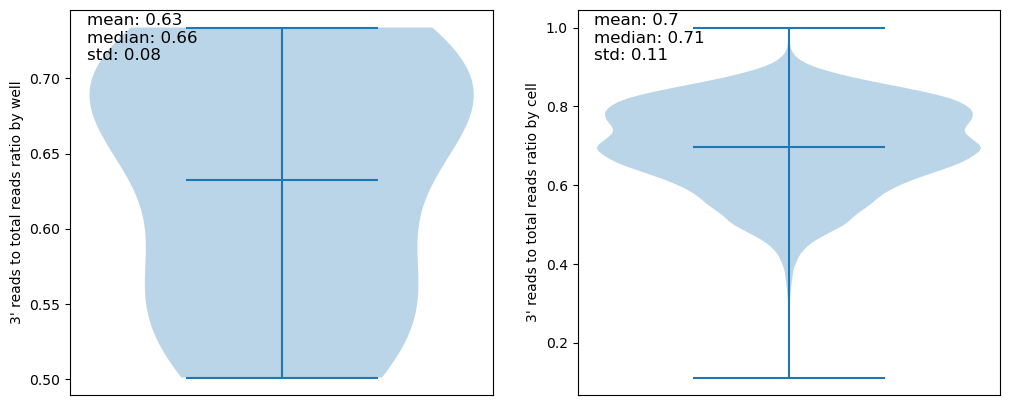

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

well_read_ratios = wells_data.obs[wells_data.obs['polyT']].groupby('well')['n_counts'].sum() / wells_data.obs.groupby('well')['n_counts'].sum()
well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

ax[0].violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[0].set_xticks([])
ax[0].set_ylabel("3' reads to total reads ratio by well") 
string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
ax[0].text(0.04, 0.87, string, transform=ax[0].transAxes, fontsize=12)

cell_read_ratios = parse_data.obs['polyT_reads'] / (parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'])
cell_read_ratios = cell_read_ratios.fillna(0)

ax[1].violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[1].set_xticks([])
ax[1].set_ylabel("3' reads to total reads ratio by cell") 
string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
ax[1].text(0.04, 0.87, string, transform=ax[1].transAxes, fontsize=12)

plt.show()


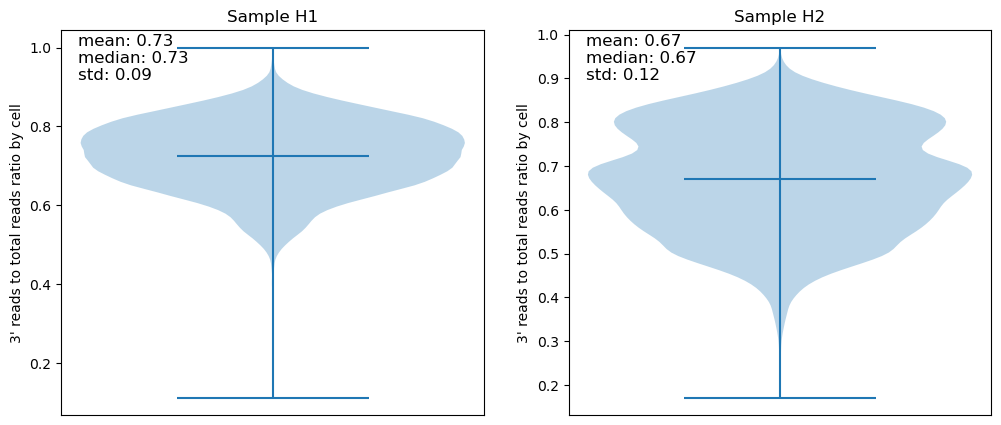

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    obs = parse_data.obs[parse_data.obs['sample']==sample_name]

    cell_read_ratios = obs['polyT_reads'] / (obs['polyT_reads'] + obs['randO_reads'])
    cell_read_ratios = cell_read_ratios.fillna(0)

    ax.violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by cell") 
    ax.set_title(f"Sample {sample_name}")
    string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

In [36]:
def plotByWell(ax, well_obs, xlim = 1.15, ylim = 1.15, corr = True):
    polyT_well_reads = well_obs[well_obs['polyT']].groupby('well')['n_counts'].sum()
    randO_well_reads = well_obs[well_obs['randO']].groupby('well')['n_counts'].sum()
    well_reads_df = pd.concat([polyT_well_reads, randO_well_reads], axis=1).fillna(0)
    well_reads_df = well_reads_df.set_axis(['polyT_reads', 'randO_reads'], axis=1)

    ax.scatter(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
    ax.set_xlabel('random oligo total reads by well')
    ax.set_ylabel('3\' total reads by well')
    max_lim = max(well_reads_df['randO_reads'].max(), well_reads_df['polyT_reads'].max())
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

def plotByCell(ax, obs, xlim = 1.15, ylim = 1.15, corr = True):
    ax.scatter(obs['randO_reads'], obs['polyT_reads'])
    ax.set_xlabel('random oligo total reads by cell')
    ax.set_ylabel('3\' total reads by cell')
    max_lim = max(obs['randO_reads'].max(), obs['polyT_reads'].max())
    ax.set_xlim(0, xlim*max_lim)
    ax.set_ylim(0, ylim*max_lim)
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(obs['randO_reads'], obs['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

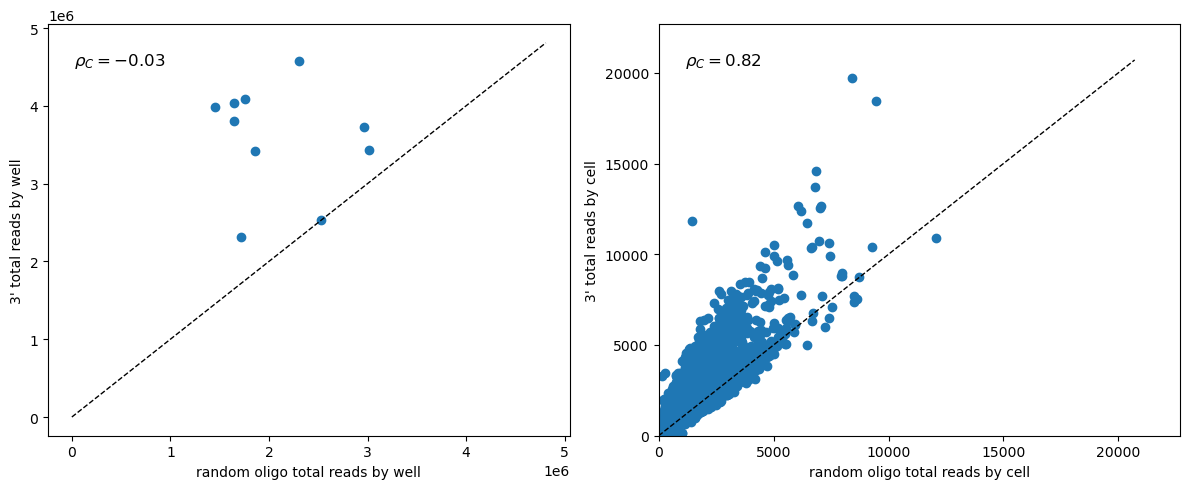

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_data.obs)
plotByCell(ax[1], parse_data.obs)

plt.tight_layout()
plt.show()

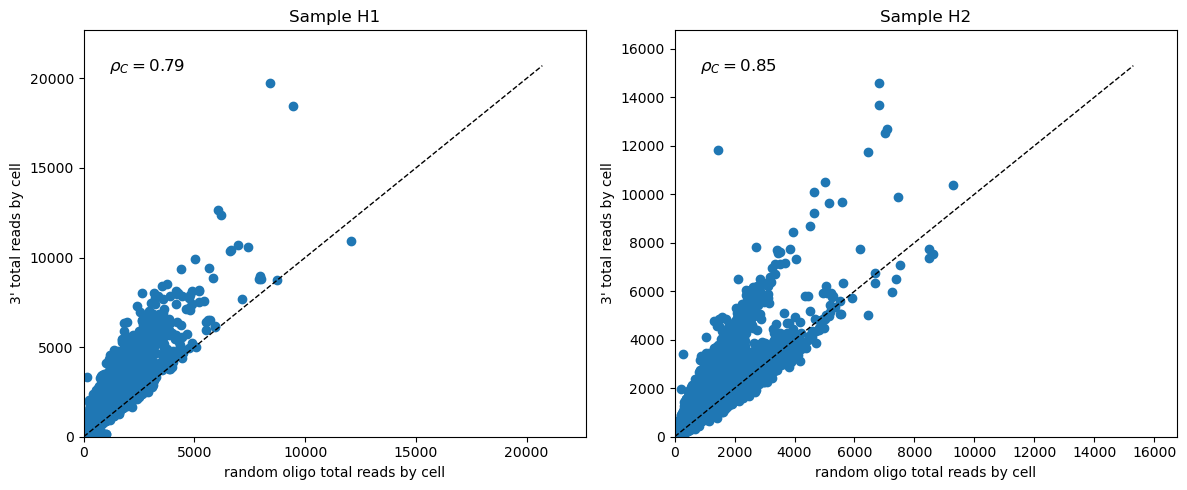

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    plotByCell(ax, parse_data.obs[parse_data.obs['sample']==sample_name])
    ax.set_title(f"Sample {sample_name}")

plt.tight_layout()
plt.show()

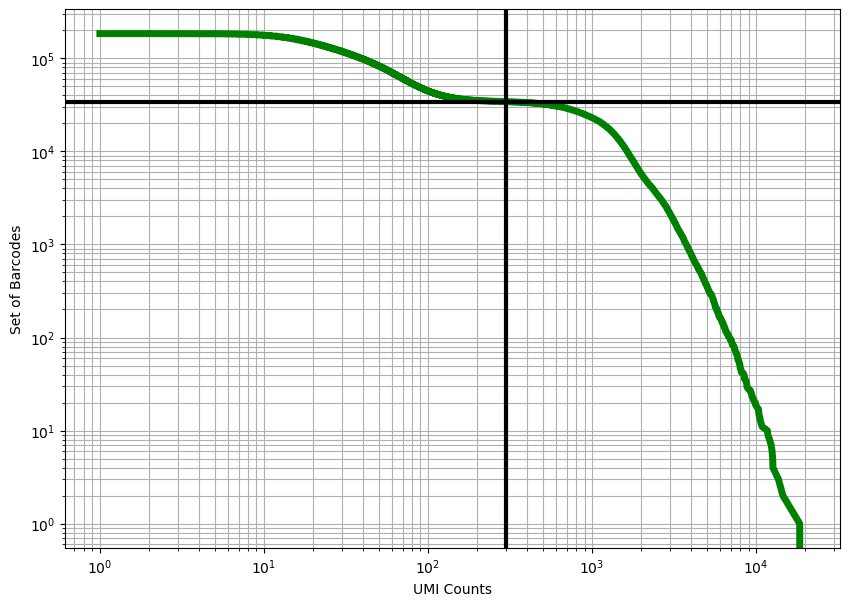

In [39]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 300  #@param {type:"integer"}
knee = np.sort((np.array(wells_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

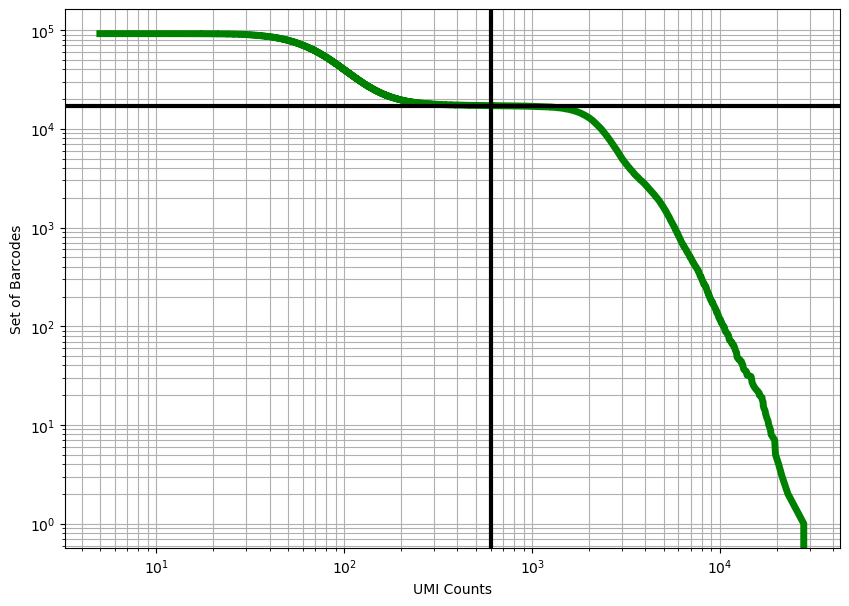

In [40]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 600  #@param {type:"integer"}
knee = np.sort((np.array(parse_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

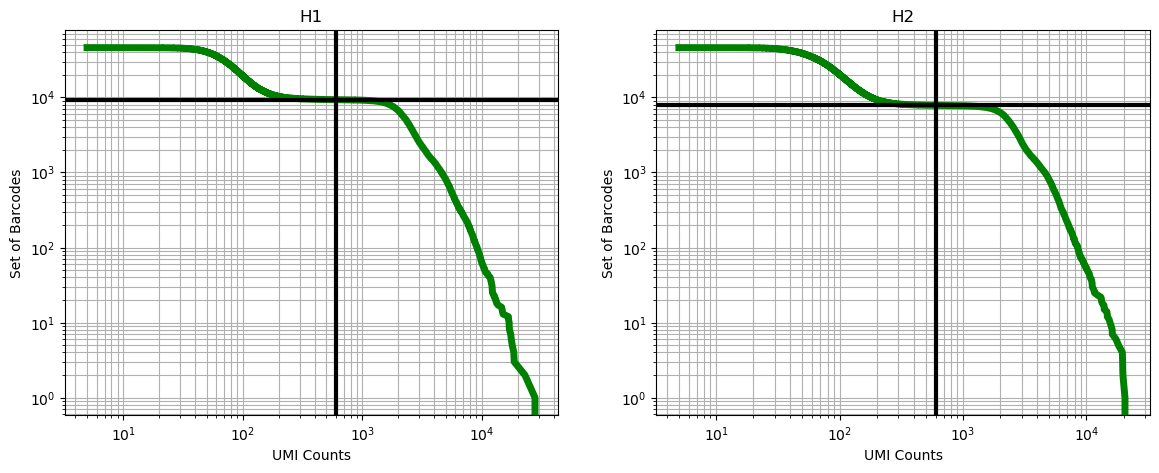

In [41]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

cutoffs = [600,600]
n_cells = []
for ax, cutoff, name in zip(axs,cutoffs,sample_names):    
    # Threshold cells according to knee plot 
    X = parse_data.X[(parse_data.obs['sample'] == name).tolist(),:]
    knee = np.sort((np.array(X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    n_cells.append(num_cells)

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")
    ax.set_title(name)
    ax.grid(True, which="both")
plt.show()

In [42]:
wells_filtered = wells_data.copy()
sc.pp.filter_cells(wells_filtered, min_counts=knee[num_cells])
parse_filtered = parse_data.copy()
sc.pp.filter_cells(parse_filtered, min_counts=knee[num_cells])

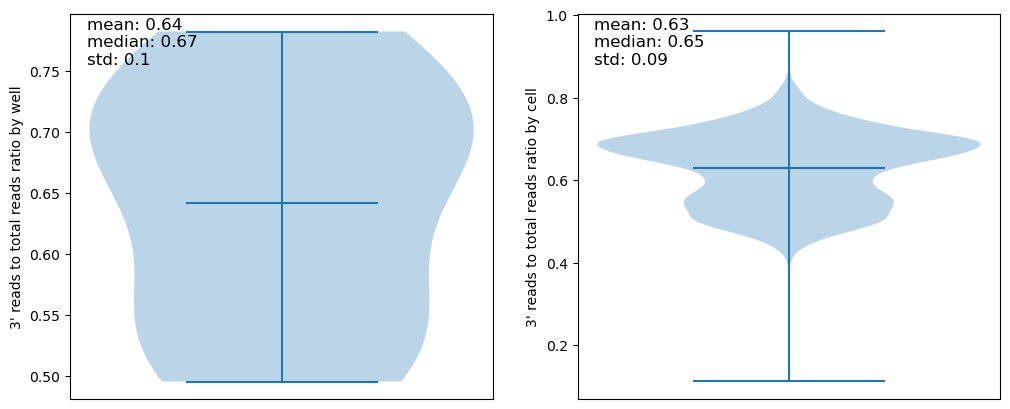

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

well_read_ratios = wells_filtered.obs[wells_filtered.obs['polyT']].groupby('well')['n_counts'].sum() / wells_filtered.obs.groupby('well')['n_counts'].sum()
well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

ax[0].violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[0].set_xticks([])
ax[0].set_ylabel("3' reads to total reads ratio by well") 
string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
ax[0].text(0.04, 0.87, string, transform=ax[0].transAxes, fontsize=12)

cell_read_ratios = parse_filtered.obs['polyT_reads'] / (parse_filtered.obs['polyT_reads'] + parse_filtered.obs['randO_reads'])
cell_read_ratios = cell_read_ratios.fillna(0)

ax[1].violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[1].set_xticks([])
ax[1].set_ylabel("3' reads to total reads ratio by cell") 
string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
ax[1].text(0.04, 0.87, string, transform=ax[1].transAxes, fontsize=12)

plt.show()

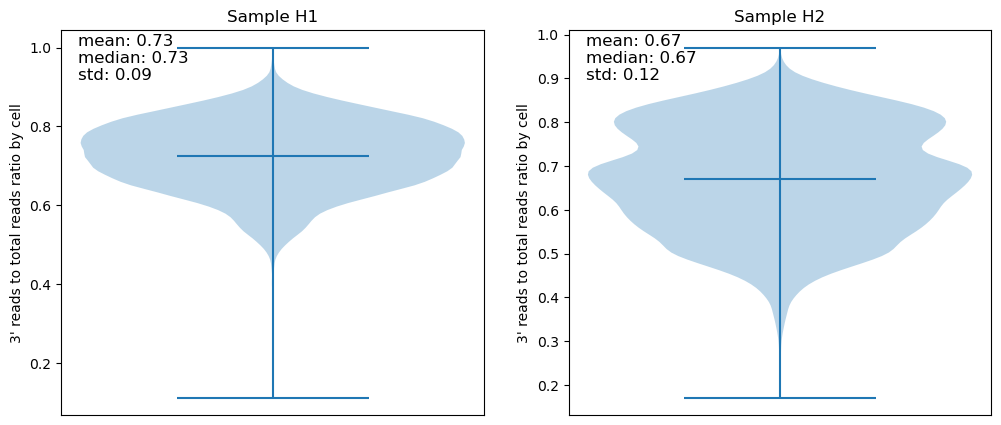

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    obs = parse_data.obs[parse_data.obs['sample']==sample_name]

    cell_read_ratios = obs['polyT_reads'] / (obs['polyT_reads'] + obs['randO_reads'])
    cell_read_ratios = cell_read_ratios.fillna(0)

    ax.violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by cell") 
    ax.set_title(f"Sample {sample_name}")
    string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

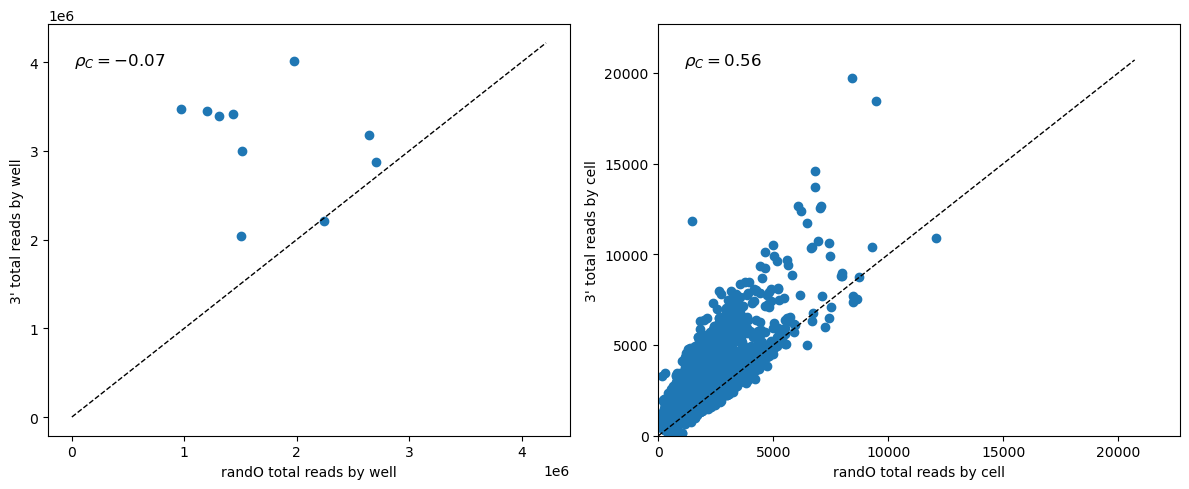

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_filtered.obs)
plotByCell(ax[1], parse_filtered.obs)

plt.tight_layout()
plt.show()

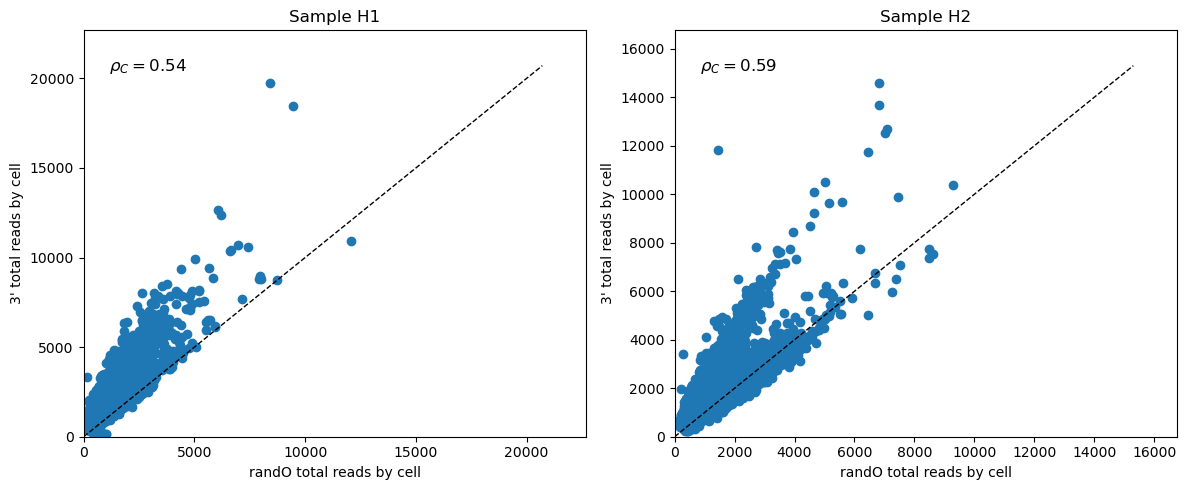

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    plotByCell(ax, parse_filtered.obs[parse_filtered.obs['sample']==sample_name])
    ax.set_title(f"Sample {sample_name}")

plt.tight_layout()
plt.show()

# Parse Read Analysis

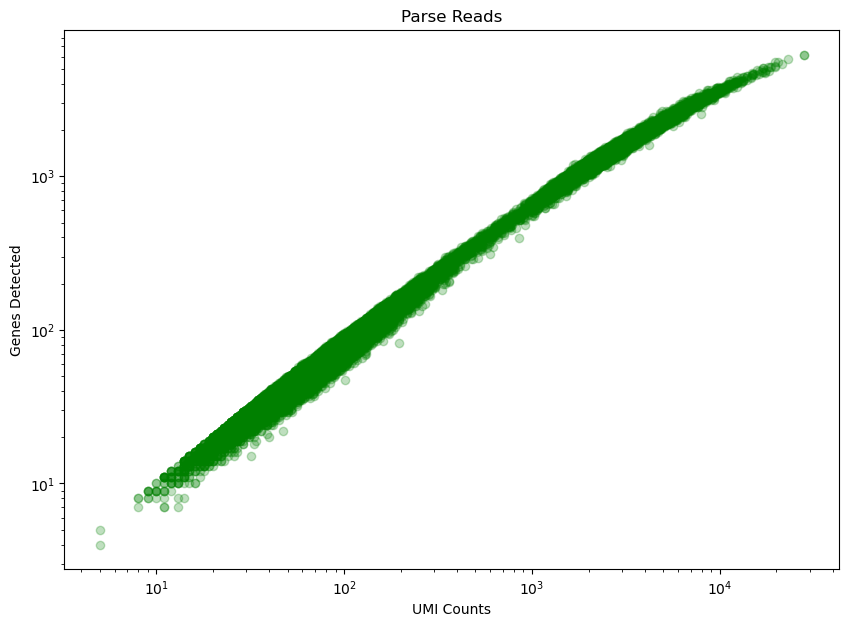

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(parse_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(parse_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("Parse Reads")

plt.show()

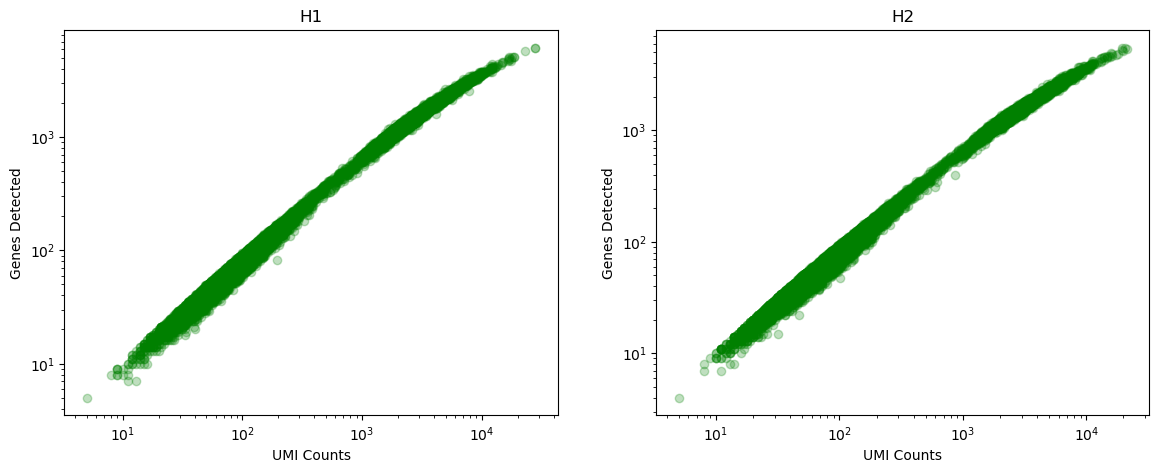

In [44]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

for ax, name in zip(axs, sample_names):
    X = parse_data.X[(parse_data.obs['sample'] == name).tolist(),:]
    x = np.asarray(X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(name)

plt.show()

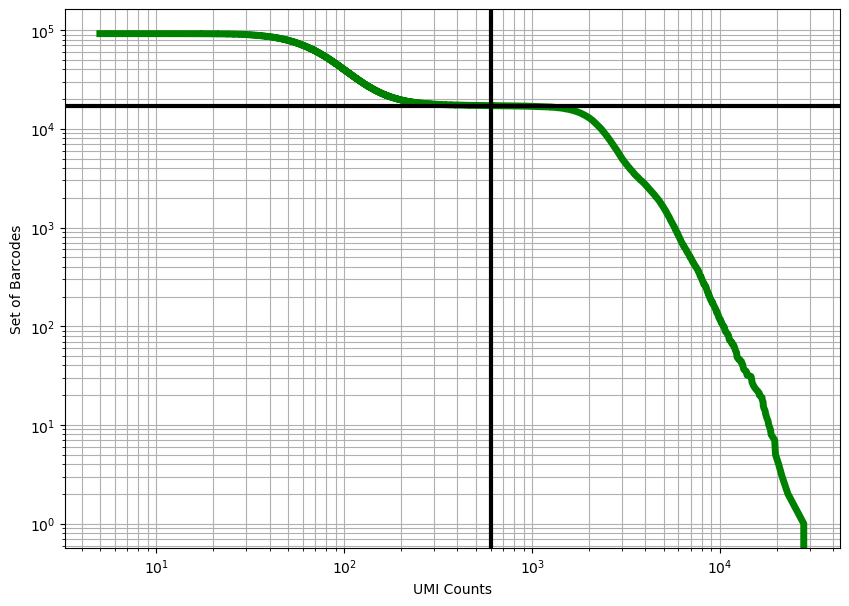

In [50]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 600  #@param {type:"integer"}
knee = np.sort((np.array(parse_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [51]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

17,170 cells passed the 600 UMI threshold


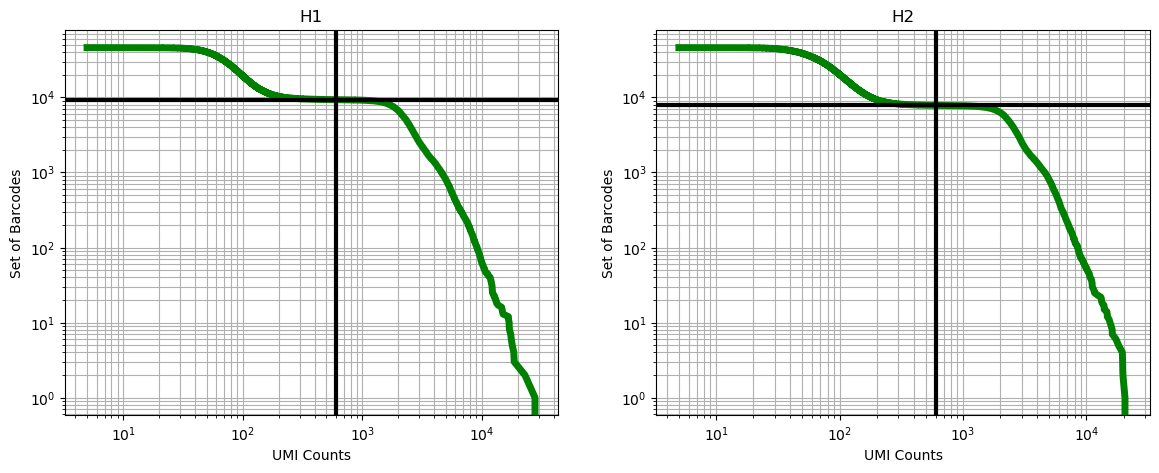

In [47]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

cutoffs = [600,600]
n_cells = []
for ax, cutoff, name in zip(axs,cutoffs,sample_names):    
    # Threshold cells according to knee plot 
    X = parse_data.X[(parse_data.obs['sample'] == name).tolist(),:]
    knee = np.sort((np.array(X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    n_cells.append(num_cells)

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")
    ax.set_title(name)
    ax.grid(True, which="both")
plt.show()

In [52]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['hsapiens_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [53]:
lncRNA_genes = set(parse_data.var["gene_ids"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [54]:
# Identify lncRNA genes
parse_data.var["is_lnc"] = np.full(len(parse_data.var_names), False)
parse_data.var.loc[parse_data.var["gene_ids"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
parse_data.var["is_mito"] = parse_data.var_names.str.startswith("MT")
# ribosomal genes
parse_data.var["is_ribo"] = parse_data.var_names.str.startswith(("RPS", "RPL"))

mito_counts = parse_data[:, parse_data.var['is_mito']].X.sum(axis=1)
ribo_counts = parse_data[:, parse_data.var['is_ribo']].X.sum(axis=1)
nc_counts = parse_data[:, parse_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = parse_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
parse_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
parse_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
parse_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

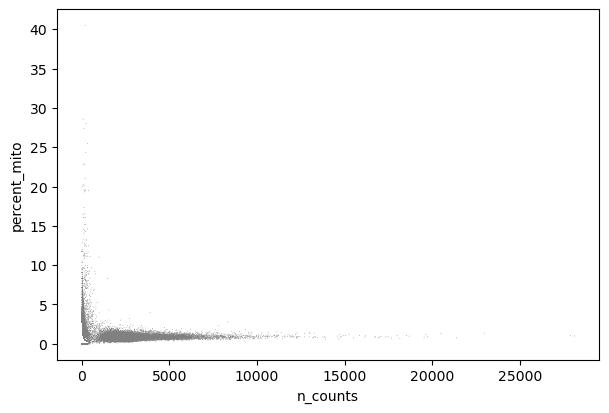

In [65]:
sc.pl.scatter(parse_data, x='n_counts', y='percent_mito')

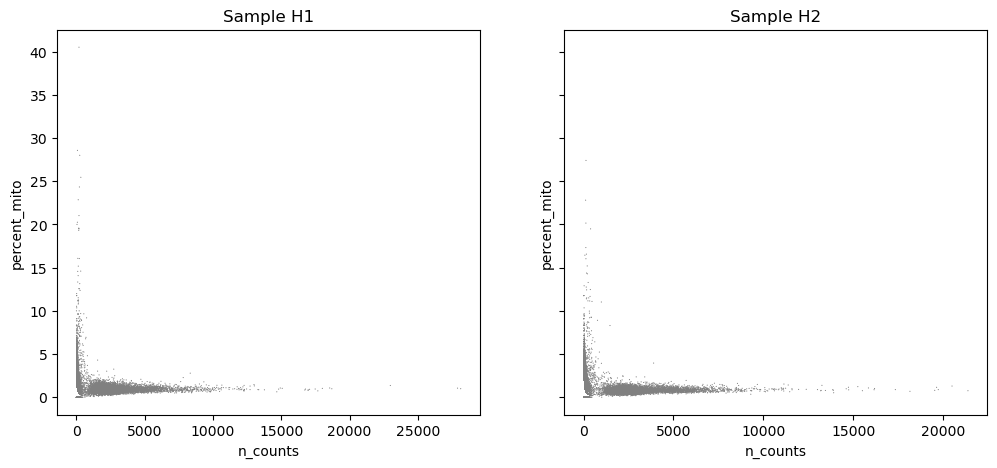

In [68]:
fig, axs = plt.subplots(1,2, figsize = (12,5), sharey=True)
for ax, sample_name in zip(axs, sample_names):
    sc.pl.scatter(parse_data[parse_data.obs['sample']==sample_name,:], 
                  x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(f"Sample {sample_name}")
plt.show()

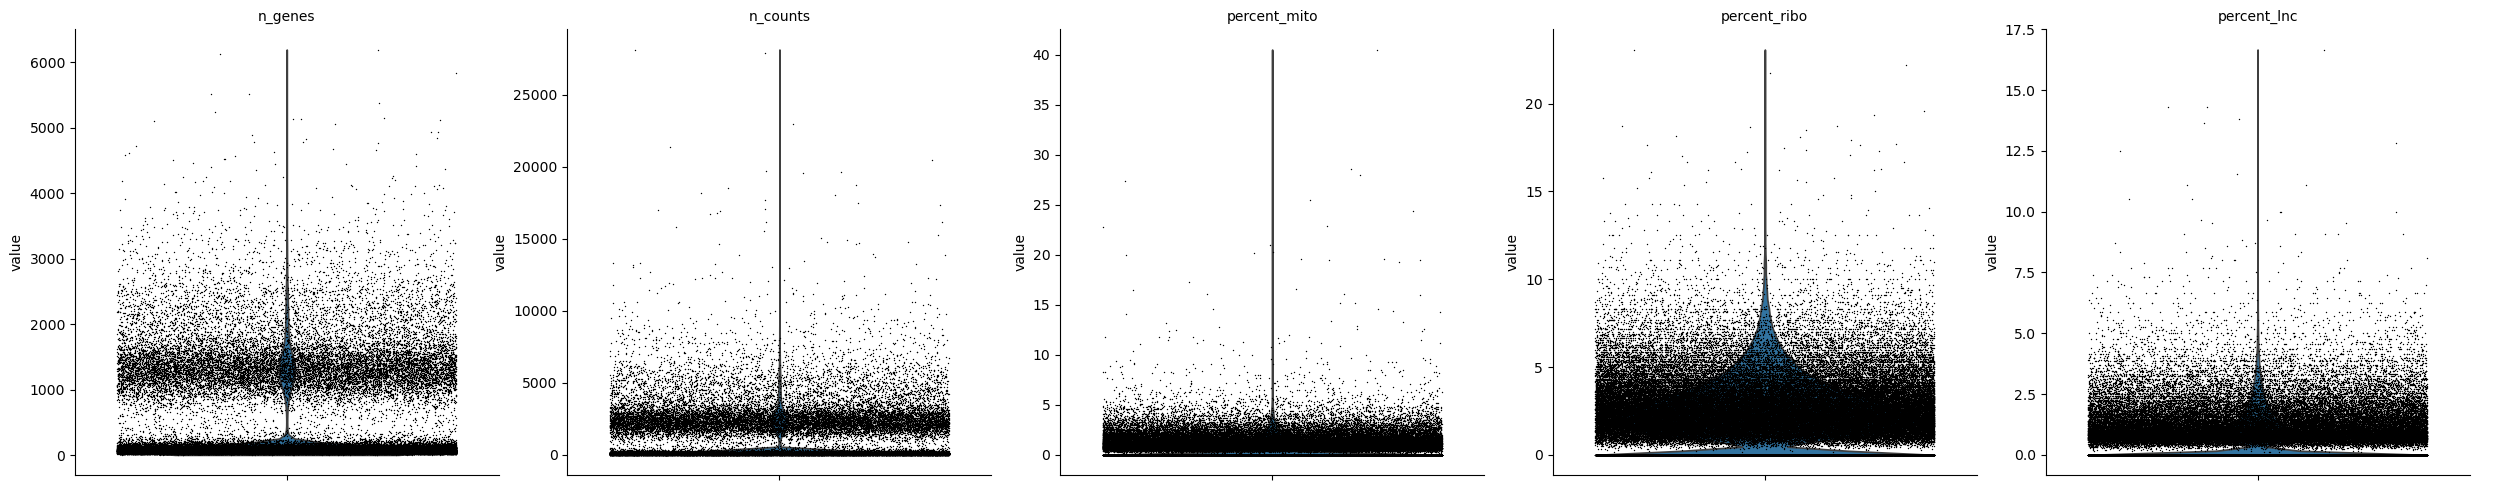

In [39]:
sc.pl.violin(parse_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

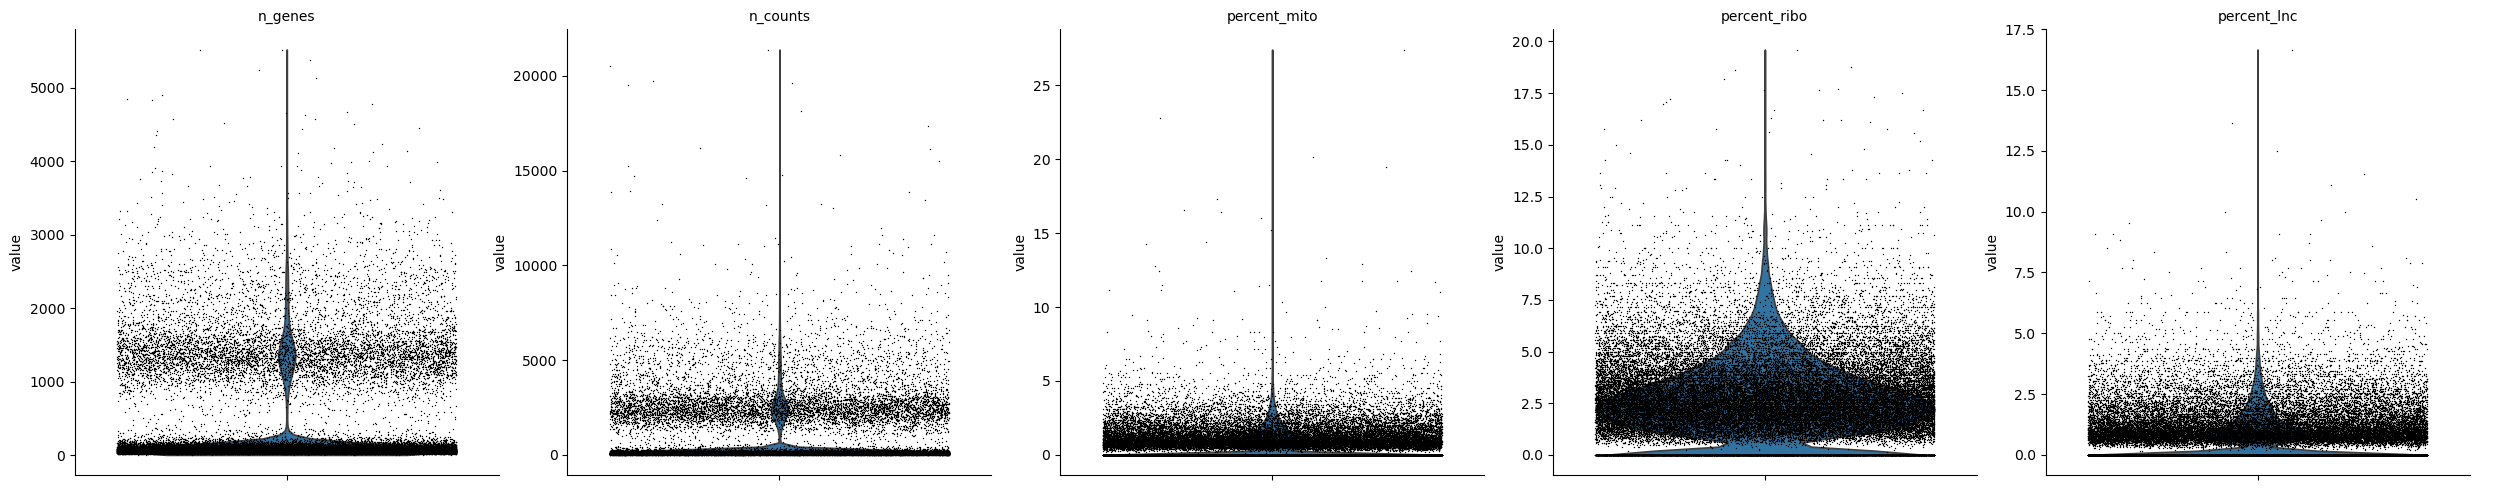

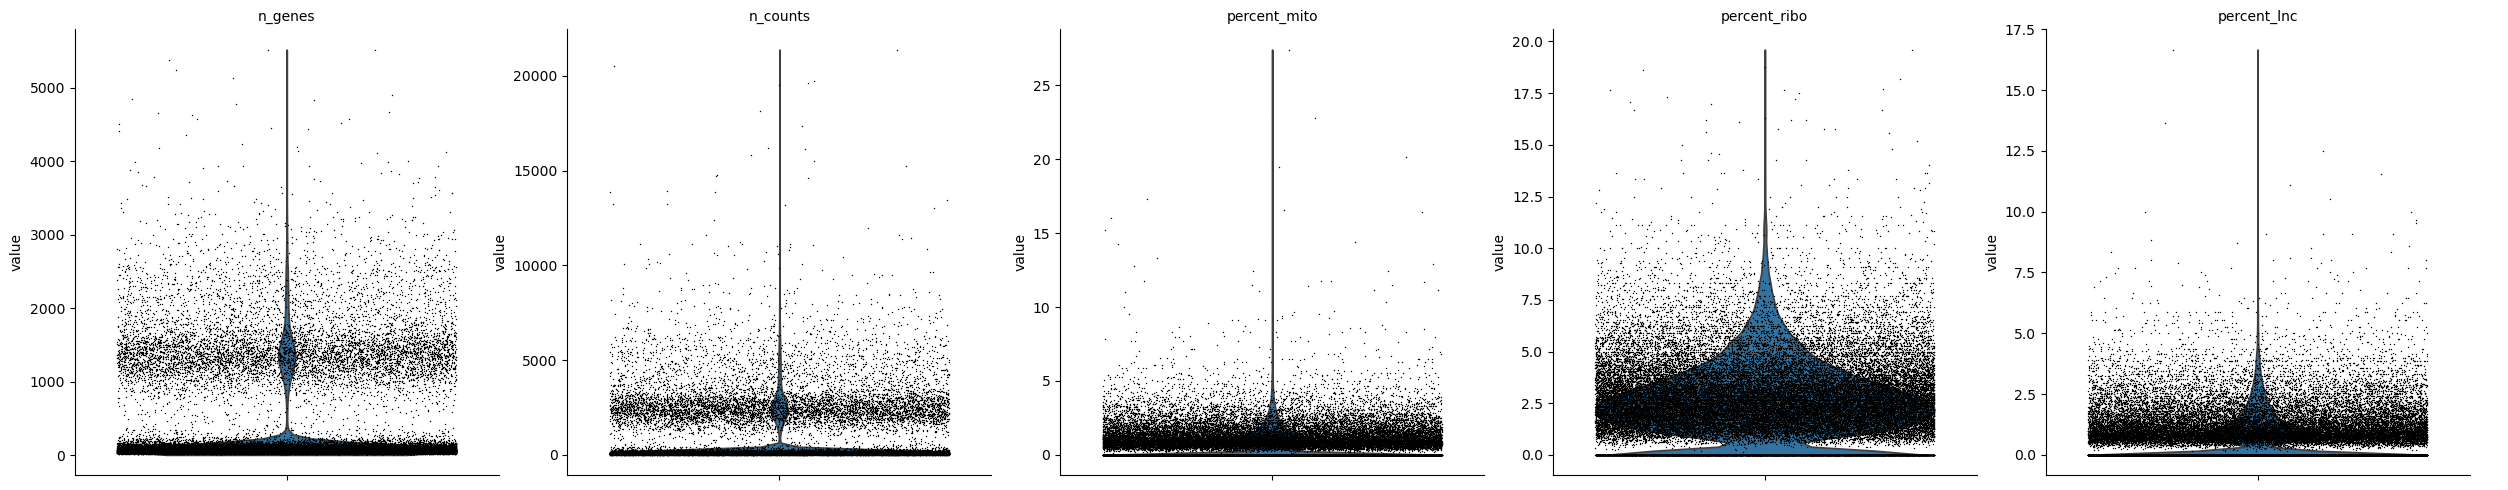

In [69]:
for sample in sample_names:
    sc.pl.violin(parse_data[parse_data.obs['sample']==sample_name,:], ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [40]:
# Find top 10 genes by number of cells they are expressed in
genes = parse_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(parse_data[:,gene].X.toarray().transpose()[0] / np.array(parse_data.obs['n_counts'].tolist()) * 100))

In [41]:
# Add percent of counts for each gene to metadata
parse_data.var['percent_counts'] = parse_data.X.sum(axis=0).A1 / parse_data.X.sum() * 100

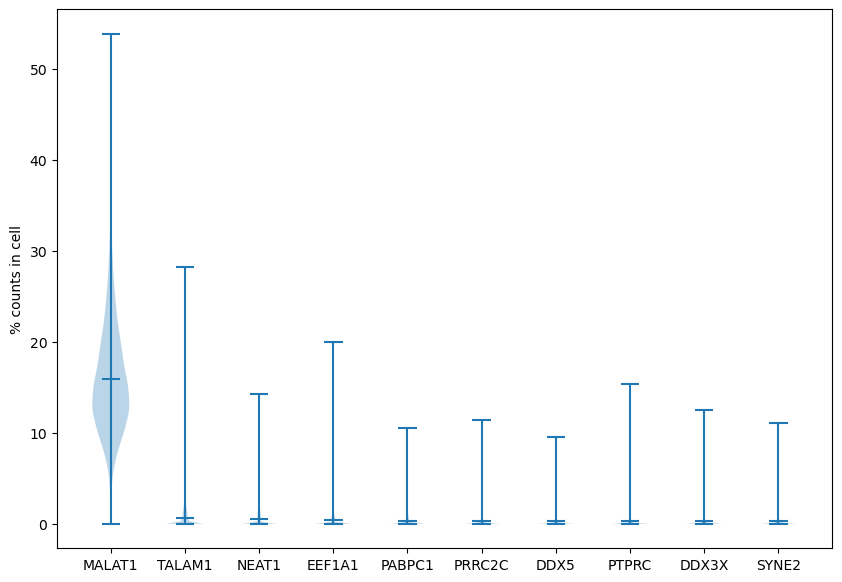

In [42]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

# Parse PolyT Read Analysis

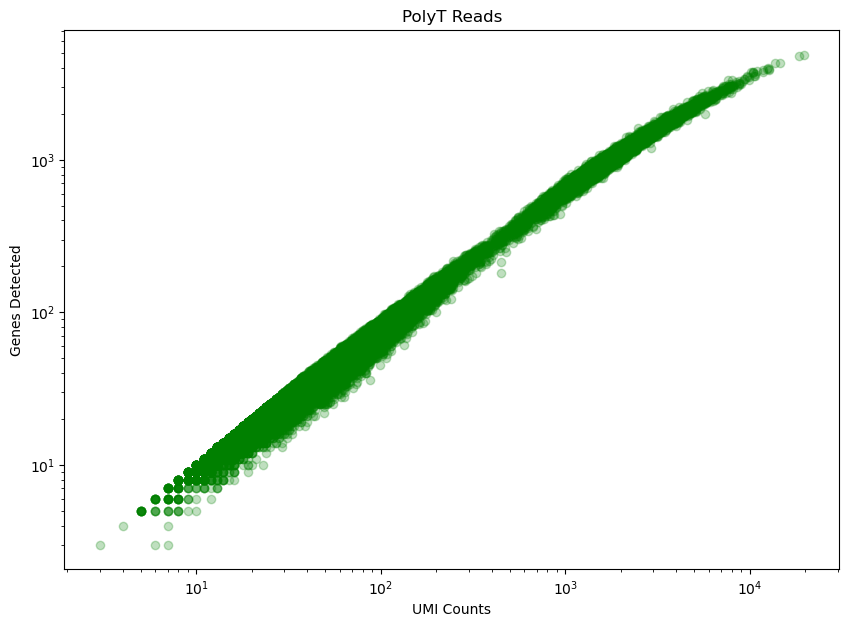

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(polyT_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(polyT_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

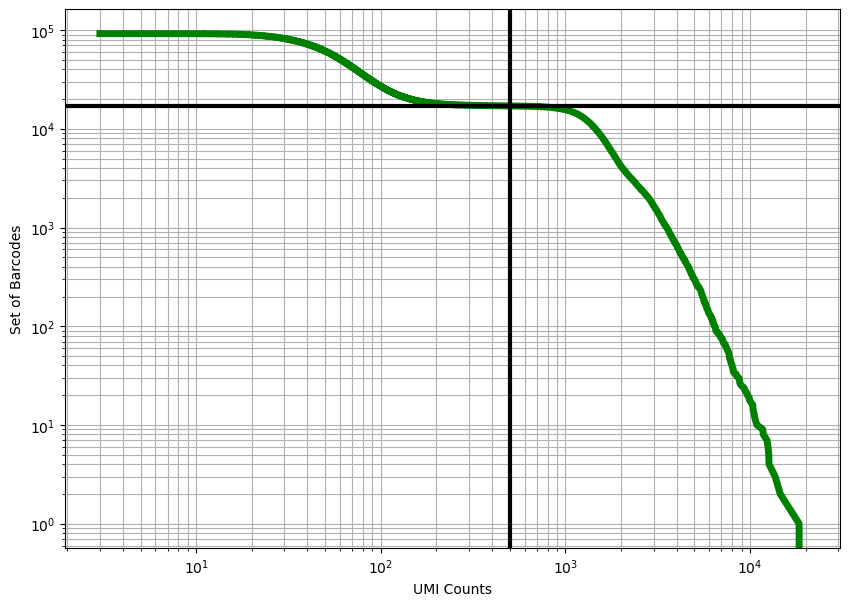

In [46]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 500  #@param {type:"integer"}
knee = np.sort((np.array(polyT_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [47]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

17,050 cells passed the 500 UMI threshold


In [ ]:
lncRNA_genes = set(polyT_data.var["gene_ids"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [ ]:
# Identify lncRNA genes
polyT_data.var["is_lnc"] = np.full(len(polyT_data.var_names), False)
polyT_data.var.loc[polyT_data.var["gene_ids"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
polyT_data.var["is_mito"] = polyT_data.var_names.str.startswith("MT")
# ribosomal genes
polyT_data.var["is_ribo"] = polyT_data.var_names.str.startswith(("RPS", "RPL"))

mito_counts = polyT_data[:, polyT_data.var['is_mito']].X.sum(axis=1)
ribo_counts = polyT_data[:, polyT_data.var['is_ribo']].X.sum(axis=1)
nc_counts = polyT_data[:, polyT_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = polyT_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
polyT_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
polyT_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
polyT_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

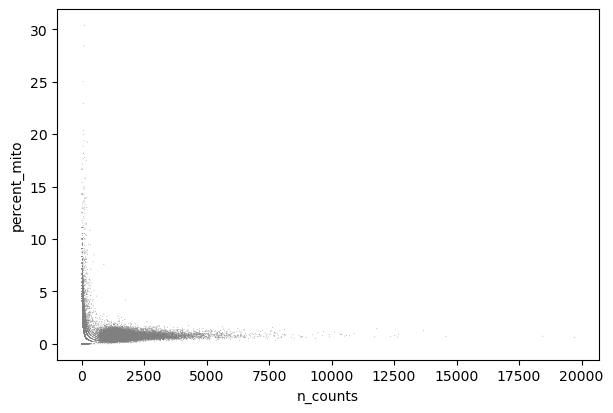

In [50]:
sc.pl.scatter(polyT_data, x='n_counts', y='percent_mito')

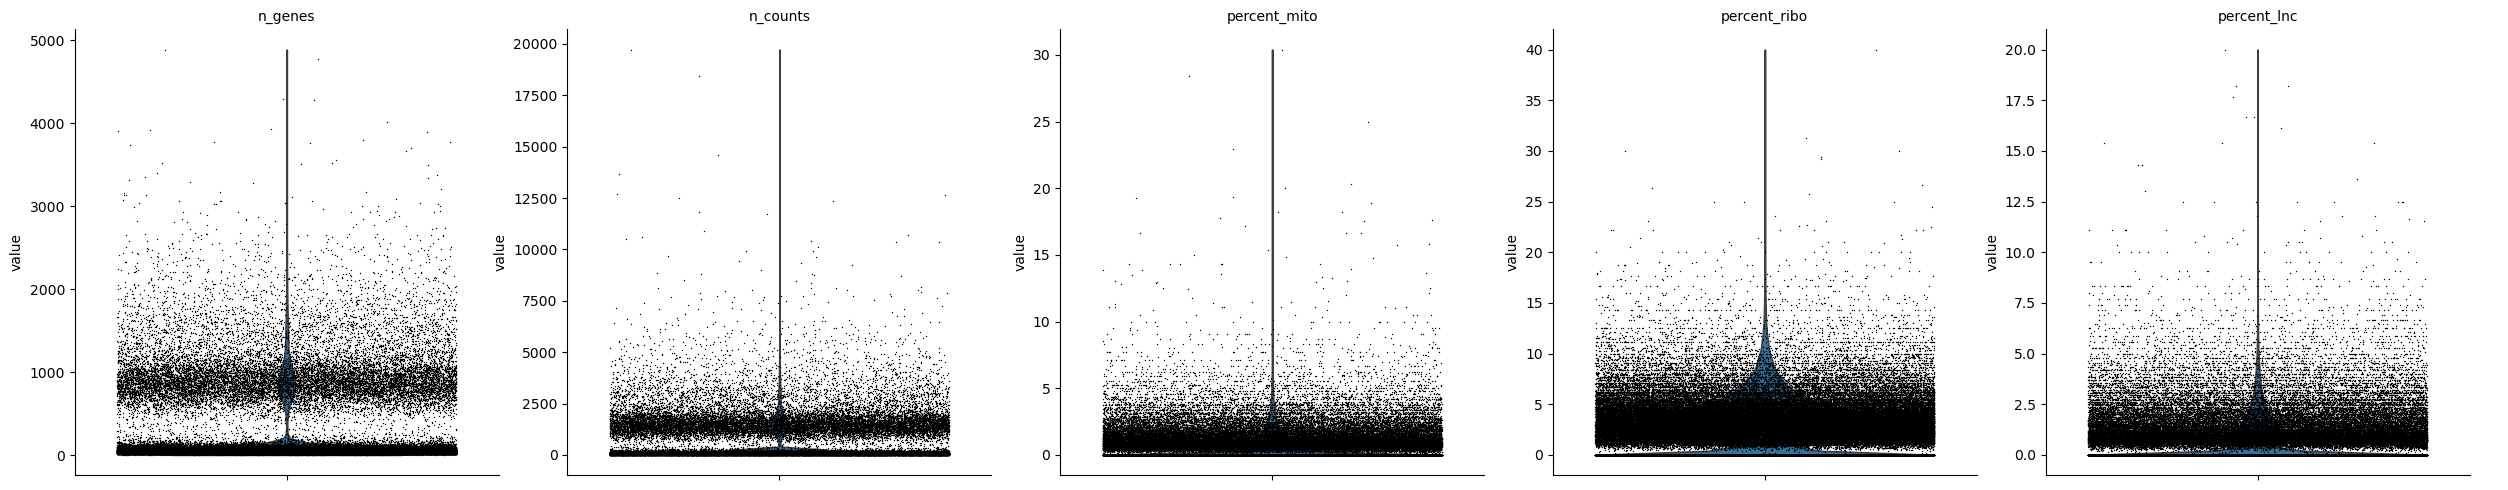

In [51]:
sc.pl.violin(polyT_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [52]:
# Find top 10 genes by number of cells they are expressed in
genes = polyT_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(polyT_data[:,gene].X.toarray().transpose()[0] / np.array(polyT_data.obs['n_counts'].tolist()) * 100))

In [53]:
# Add percent of counts for each gene to metadata
polyT_data.var['percent_counts'] = polyT_data.X.sum(axis=0).A1 / polyT_data.X.sum() * 100

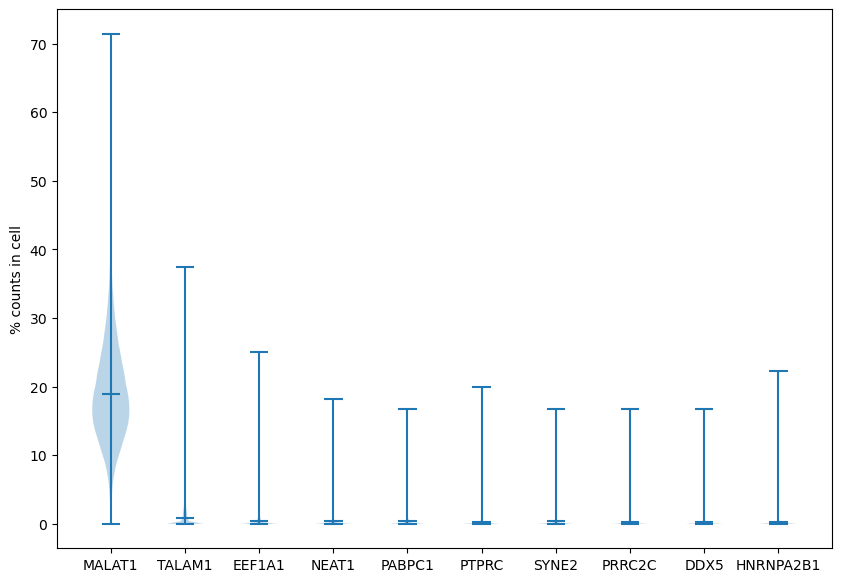

In [54]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

# Parse RandO Read Analysis

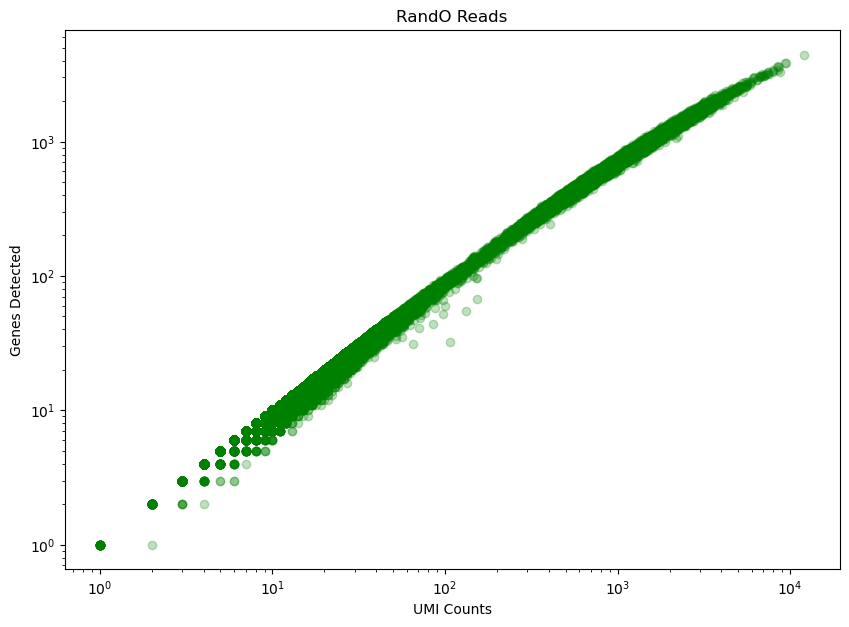

In [55]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(randO_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(randO_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("RandO Reads")

plt.show()

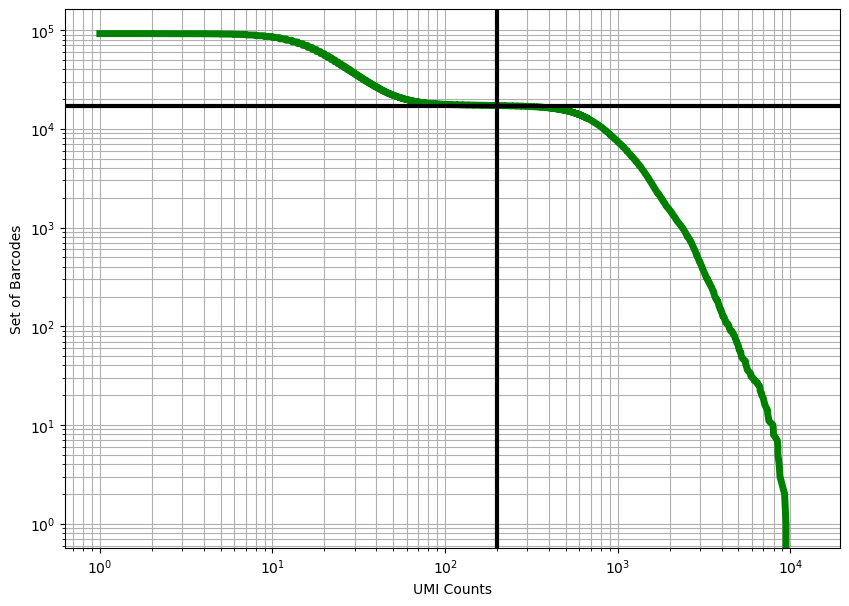

In [59]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 200  #@param {type:"integer"}
knee = np.sort((np.array(randO_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [60]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

17,201 cells passed the 200 UMI threshold


In [ ]:
lncRNA_genes = set(randO_data.var["gene_ids"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [ ]:
# Identify lncRNA genes
randO_data.var["is_lnc"] = np.full(len(randO_data.var_names), False)
randO_data.var.loc[randO_data.var["gene_ids"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
randO_data.var["is_mito"] = randO_data.var_names.str.startswith("MT")
# ribosomal genes
randO_data.var["is_ribo"] = randO_data.var_names.str.startswith(("RPS", "RPL"))

mito_counts = randO_data[:, randO_data.var['is_mito']].X.sum(axis=1)
ribo_counts = randO_data[:, randO_data.var['is_ribo']].X.sum(axis=1)
lnc_counts = randO_data[:, randO_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = randO_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
randO_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
randO_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
randO_data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

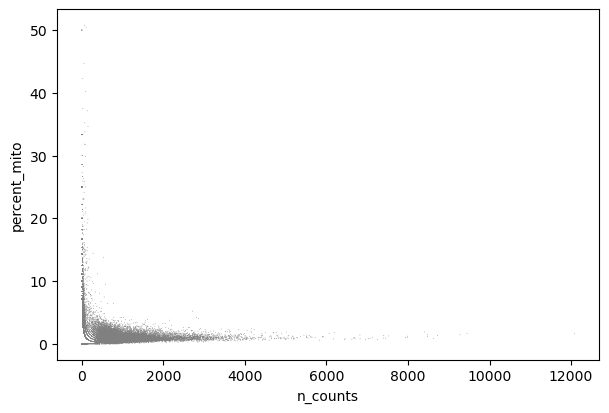

In [63]:
sc.pl.scatter(randO_data, x='n_counts', y='percent_mito')

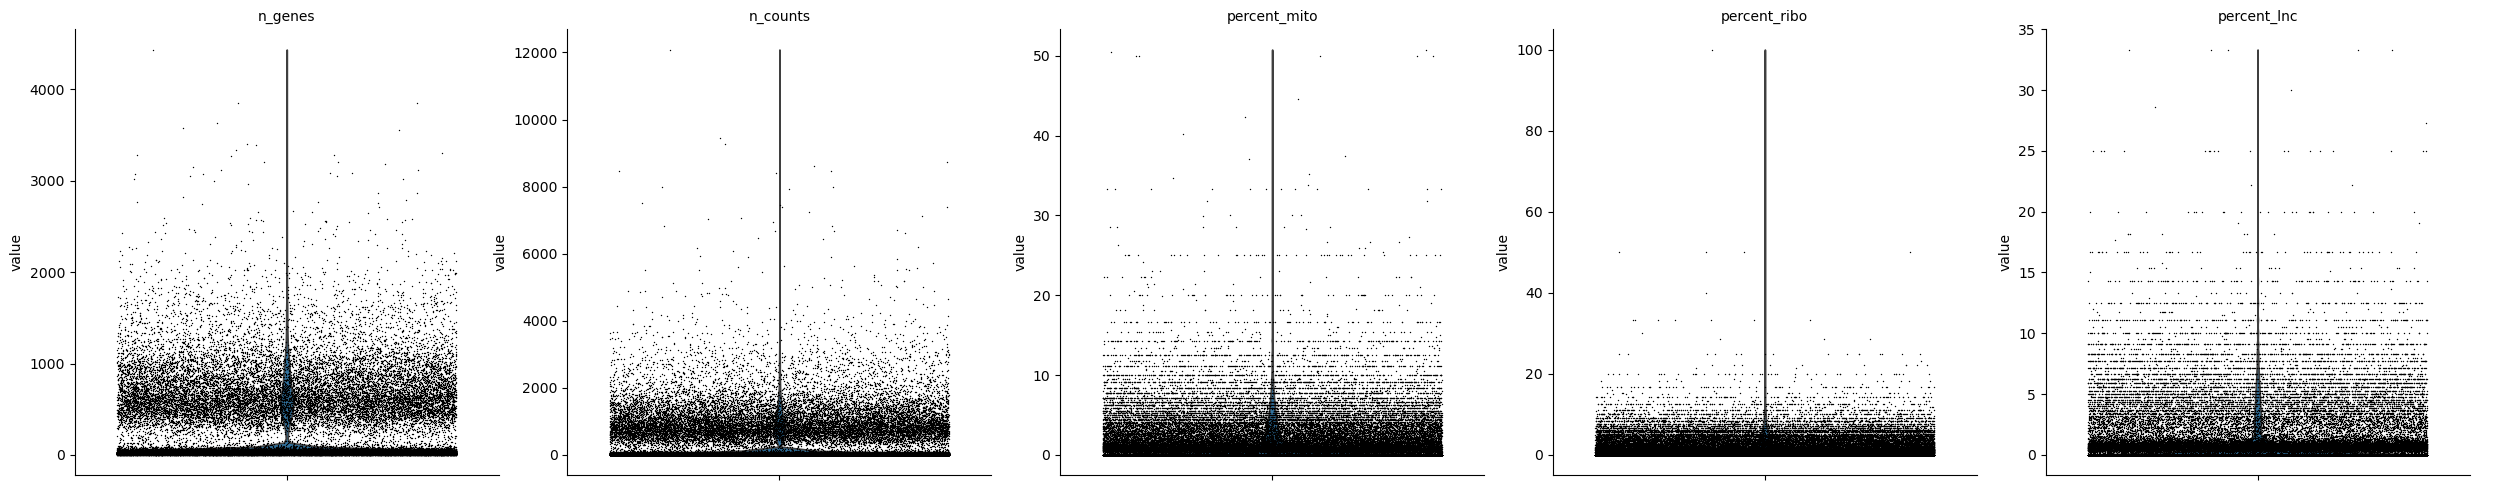

In [64]:
sc.pl.violin(randO_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [65]:
# Find top 10 genes by number of cells they are expressed in
genes = randO_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(randO_data[:,gene].X.toarray().transpose()[0] / np.array(randO_data.obs['n_counts'].tolist()) * 100))

In [66]:
# Add percent of counts for each gene to metadata
randO_data.var['percent_counts'] = randO_data.X.sum(axis=0).A1  / randO_data.X.sum() * 100

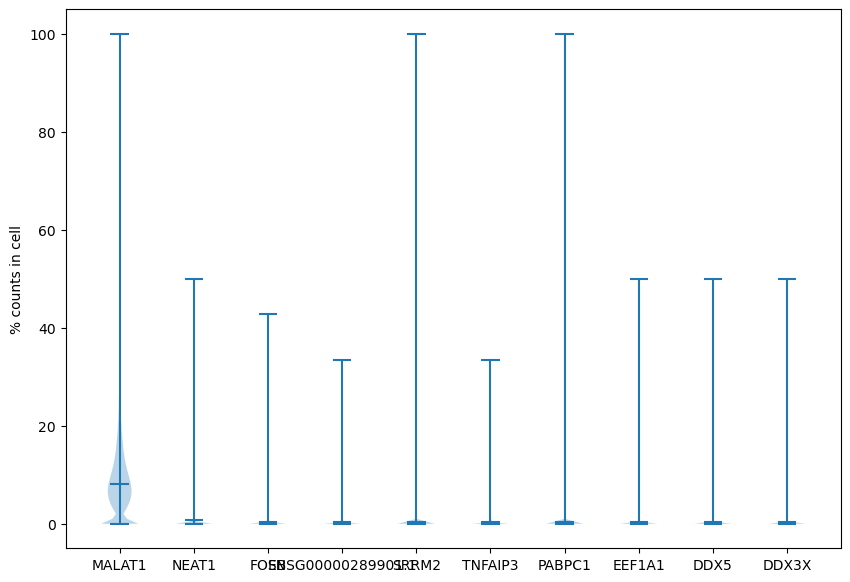

In [67]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()